# Dive into time periods of change

This notebook is designed to further examine individual changepoints that occurred in [01_change_point_detection.ipynb](01_change_point_detection.ipynb) and [02_changepoint_detection_comparison](02_changepoint_detection_comparison).

In [1]:
from IPython import display
from pathlib import Path
import re

from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy
from upsetplot import from_memberships, UpSet, from_indicators
import wordcloud

## Load the changepoint predictions

In [2]:
change_point_df = pd.read_csv(
    "output/cusum_changepoint_abstracts.tsv", sep="\t"
) >> ply.define(tok=r'tok.str.replace("\-", "-", regex=False)')
change_point_df >> ply.slice_rows(10)

,tok,changepoint_idx,start_idx,end_idx,value
0,/5-,2016-2017,2015-2016,2016-2017,11.948682
1,/5-,2017-2018,2016-2017,2017-2018,-11.968209
2,/disease,2017-2018,2016-2017,2017-2018,12.327052
3,/disease,2018-2019,2017-2018,2018-2019,-12.264762
4,/ftc,2011-2012,2010-2011,2011-2012,11.435107
5,/gr,2016-2017,2015-2016,2016-2017,11.514803
6,/gr,2017-2018,2016-2017,2017-2018,-11.652937
7,/hypocretin,2014-2015,2013-2014,2014-2015,-11.475328
8,008,2008-2009,2007-2008,2008-2009,-12.270979
9,009,2009-2010,2008-2009,2009-2010,-31.879759


In [3]:
change_metric_df = pd.read_csv(
    "output/change_metric_abstracts.tsv", sep="\t", na_filter=False
)
change_metric_df >> ply.slice_rows(10)

,year_pair,tok,ratio_metric,frequency_ratio,change_metric_ratio
0,2000-2001,!,2.250108,1.003918,3.254026
1,2000-2001,drop,2.380378,0.988707,3.369085
2,2000-2001,cfu,1.886854,0.717084,2.603938
3,2000-2001,interaction,1.765145,0.851699,2.616845
4,2000-2001,m2,2.155668,1.055401,3.211069
5,2000-2001,various,1.917591,0.963969,2.881560
6,2000-2001,pearson,2.151891,1.003918,3.155809
7,2000-2001,hdl\-,1.795933,8.365982,10.161915
8,2000-2001,driving,1.916479,0.941173,2.857652
9,2000-2001,mrs,1.877145,0.772244,2.649389


## Load the word vector model and their indicies

In [4]:
word_models = list(Path("../multi_model_experiment/output/models").rglob("*/*model"))
word_models[0:2]

[PosixPath('../multi_model_experiment/output/models/2003/2003_0.model'),
 PosixPath('../multi_model_experiment/output/models/2003/2003_5.model')]

In [5]:
word_model_map = dict()
for word_model in word_models:
    match_obj = re.search(r"(\d+)_(\d).model", str(word_model))

    year = int(match_obj.group(1))
    if year not in word_model_map:
        word_model_map[year] = list()

    word_model_map[year].append(str(word_model))

In [6]:
word_model_loaded_map = {
    key: Word2Vec.load(sorted(word_model_map[key])[0]) for key in word_model_map
}

In [7]:
word_freq_count_cutoff = 30

In [8]:
word_model_cutoff_map = {
    key: {
        "model": word_model_loaded_map[key],
        "cutoff_index": min(
            map(
                lambda x: 999999
                if word_model_loaded_map[key].wv.get_vecattr(x[1], "count")
                > word_freq_count_cutoff
                else x[0],
                enumerate(word_model_loaded_map[key].wv.index_to_key),
            )
        ),
    }
    for key in word_model_loaded_map
}

# Examine Handpicked Tokens with a high chance of Change

In [9]:
# Only used in this notebook
def examine_words_at_timepoint_range(
    word_model_map: dict, years_to_examine: list, tok: str = "the", topn: int = 25
):
    word_map = dict()
    for year in years_to_examine:
        vocab = list(word_model_map[year]["model"].wv.key_to_index.keys())
        if tok in vocab:
            word_neighbors = word_model_map[year]["model"].wv.most_similar(
                tok, topn=topn, clip_end=word_model_map[year]["cutoff_index"]
            )
            for neighbor in word_neighbors:
                if year not in word_map:
                    word_map[year] = list()

                word_map[year].append(neighbor[0])
    return word_map

In [10]:
def plot_values(
    metric_df: pd.DataFrame, changepoint_df: pd.DataFrame, tok: str = "the"
):
    metric_plot = (
        p9.ggplot(
            metric_df
            >> ply.query(f"tok=='{tok}'")
            >> ply_tdy.gather("metric", "value", ["ratio_metric", "frequency_ratio"])
        )
        + p9.aes(x="year_pair", y="value", group="metric", color="metric")
        + p9.geom_point()
        + p9.geom_line()
        + p9.coord_flip()
        + p9.scale_color_brewer(type="qual", palette=2)
        + p9.theme_seaborn("white")
        + p9.labs(
            x="Year Shift",
            y="Ratio",
            title=f"Frequency + Semantic Ratio for Token ('{tok}')",
        )
    )

    cusum_years_predicted = (
        changepoint_df >> ply.query(f"tok == '{tok}'") >> ply.pull("changepoint_idx")
    )

    for year in cusum_years_predicted:
        metric_plot += p9.annotate(
            "point",
            x=year,
            y=(
                metric_df
                >> ply.query(f"tok=='{tok}'")
                >> ply.query(f"year_pair=='{year}'")
                >> ply.pull("frequency_ratio")
            )[0],
            fill="red",
            size=4,
        )

        metric_plot += p9.annotate(
            "point",
            x=year,
            y=(
                metric_df
                >> ply.query(f"tok=='{tok}'")
                >> ply.query(f"year_pair=='{year}'")
                >> ply.pull("ratio_metric")
            )[0],
            fill="red",
            size=4,
        )

    return metric_plot

In [11]:
figure_output_path = Path("output/figures")

## Pandemic

COVID-19. The drastic shift that came from the pandemic that was first talked about in 2019 but became more prevalent in 2020.

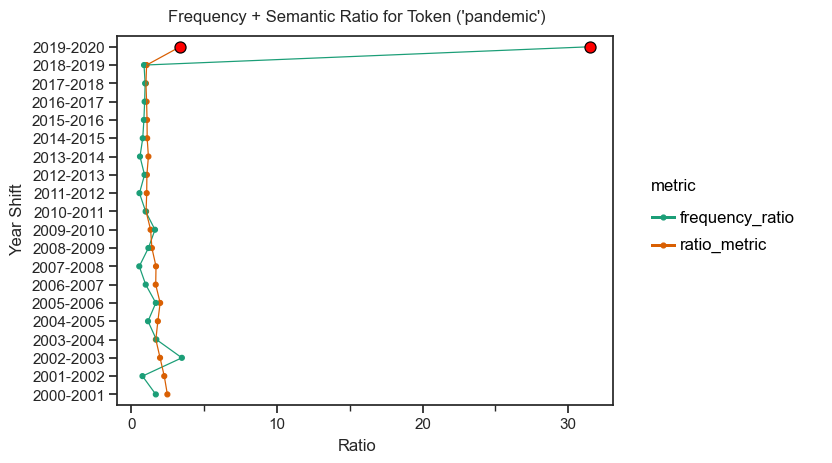

<ggplot: (8776122557616)>

In [12]:
plot_values(change_metric_df, change_point_df, tok="pandemic")

In [13]:
token_map = examine_words_at_timepoint_range(
    word_model_cutoff_map, [2017, 2018, 2019, 2020], tok="pandemic", topn=10
)
token_map

{2017: ['pandemics',
  'epidemic',
  'epidemics',
  'h7n9',
  'outbreak',
  'h5n1',
  'outbreaks',
  'h3n2',
  'h1n1',
  'influenza_virus'],
 2018: ['pandemics',
  'epidemics',
  'epidemic',
  '1918',
  'outbreaks',
  'outbreak',
  'h1n1',
  'influenza_infection',
  'influenza',
  'h7n9'],
 2019: ['epidemic',
  'pandemics',
  'epidemics',
  '1918',
  'outbreak',
  'outbreaks',
  'hpai',
  'h7n9',
  'h1n1',
  'influenza'],
 2020: ['crisis',
  'outbreak',
  'pandemics',
  'epidemic',
  'lockdown',
  'surge',
  'crises',
  'lockdowns',
  'emergencies',
  'redeployment']}

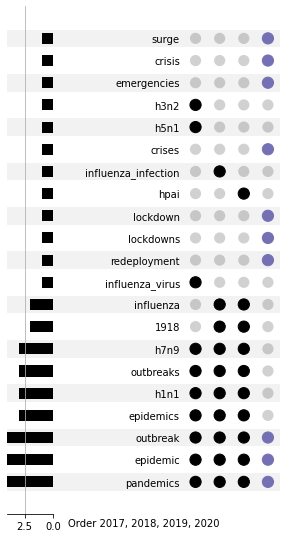

In [14]:
tokens = from_memberships(token_map.values())
fig = plt.figure(figsize=(11, 8))
upset = UpSet(
    tokens,
    with_lines=False,
    show_counts=False,
    sort_by="cardinality",
    intersection_plot_elements=0,
)
upset.style_subsets(present="lockdown", facecolor="#7570b3", label="2020")
axes = UpSet.plot(upset, fig=fig)
axes["shading"].set_xlabel("Order 2017, 2018, 2019, 2020")
fig.savefig(f"{str(figure_output_path)}/pandemic_changepoint.svg")
fig.savefig(f"{str(figure_output_path)}/pandemic_changepoint.png", dpi=500)

## Rituximab

Not sure the change here but seems like the time period is when the drug was being used to treat rheumatoid arthritis. More investigation is needed.

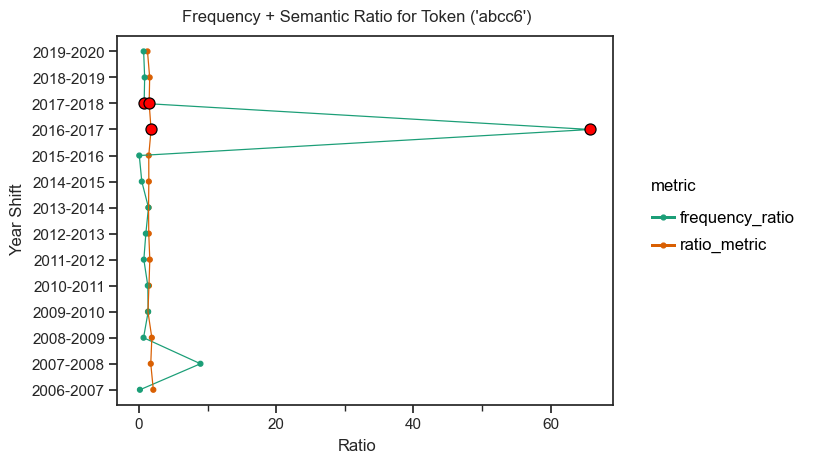

<ggplot: (-9223363260732759601)>

In [15]:
plot_values(change_metric_df, change_point_df, tok="abcc6")

In [16]:
token_map = examine_words_at_timepoint_range(
    word_model_cutoff_map,
    [2014, 2015, 2016, 2017, 2018],
    tok="abcc6",
    topn=10,
)

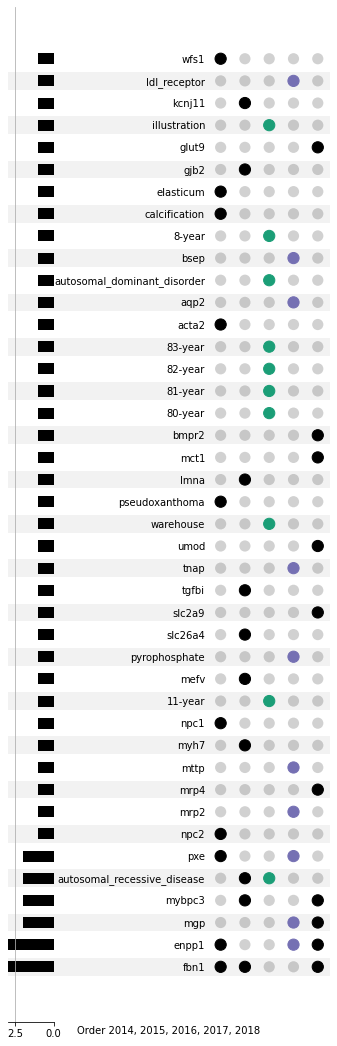

In [17]:
tokens = from_memberships(token_map.values())
fig = plt.figure(figsize=(11, 8))
upset = UpSet(
    tokens,
    with_lines=False,
    sort_by="cardinality",
    intersection_plot_elements=0,
)
upset.style_subsets(present="83-year", facecolor="#1b9e77", label="2005")
upset.style_subsets(present="mrp2", facecolor="#7570b3", label="2006")
axes = UpSet.plot(upset, fig=fig)
axes["shading"].set_xlabel("Order 2014, 2015, 2016, 2017, 2018")
fig.savefig(f"{str(figure_output_path)}/abcc6_changepoint.svg")
fig.savefig(f"{str(figure_output_path)}/abcc6_changepoint.png", dpi=500)

## Asthma

There is semantic shift for asthma where in 2002-2003 seems like focus shifted from co-morbidity to drug treatments. Fun fact asthma is connected to type 2 diabetes (had no idea).

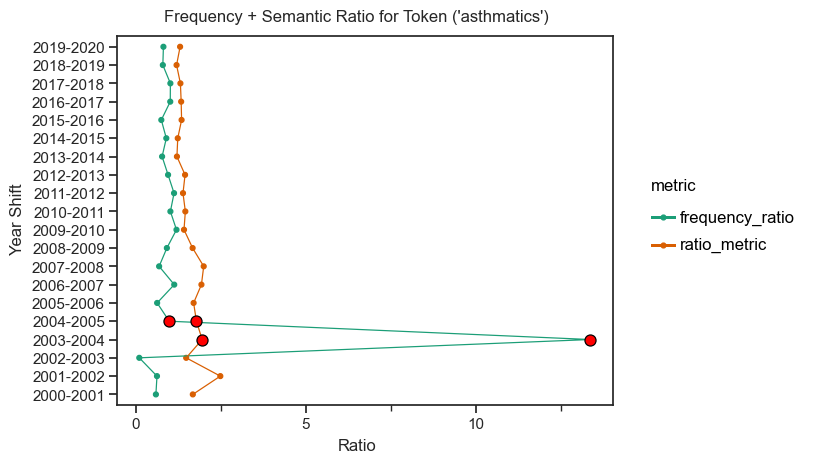

<ggplot: (8776121416666)>

In [18]:
plot_values(change_metric_df, change_point_df, tok="asthmatics")

In [19]:
token_map = examine_words_at_timepoint_range(
    word_model_cutoff_map,
    [2003, 2004, 2005, 2006, 2007],
    tok="asthmatics",
    topn=5,
)
token_map

{2003: ['chemotaxis', '-based', 'trail', 'triggered', 'stimulates'],
 2004: ['inhaled', 'newborn', 'neonates', 'igg1', 'mild'],
 2005: ['atopic', 'sensitized', 'balf', 'asthmatic', 'eosinophils'],
 2006: ['asthmatic', 'airways', 'airway', 'neutrophils', 'lungs'],
 2007: ['airway', 'atopic', 'methacholine', 'asthmatic', 'pulmonary']}

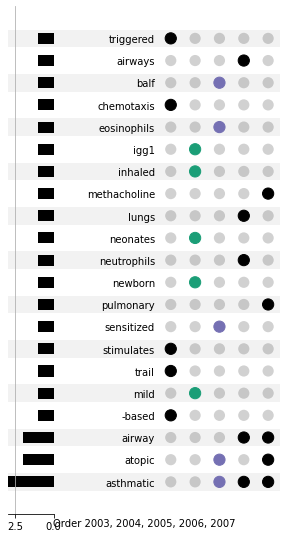

In [20]:
tokens = from_memberships(token_map.values())
fig = plt.figure(figsize=(11, 8))
upset = UpSet(
    tokens,
    with_lines=False,
    show_counts=False,
    sort_by="cardinality",
    intersection_plot_elements=0,
)
upset.style_subsets(present="newborn", facecolor="#1b9e77")
upset.style_subsets(present="balf", facecolor="#7570b3")
axes = UpSet.plot(upset, fig=fig)
axes["shading"].set_xlabel("Order 2003, 2004, 2005, 2006, 2007")
fig.savefig(f"{str(figure_output_path)}/asthmatics_changepoint.svg")
fig.savefig(f"{str(figure_output_path)}/asthmatics_changepoint.png", dpi=500)

## Atoms

This shift seems to involve moving from analyzing DNA structure to more of an individual molecule focus.

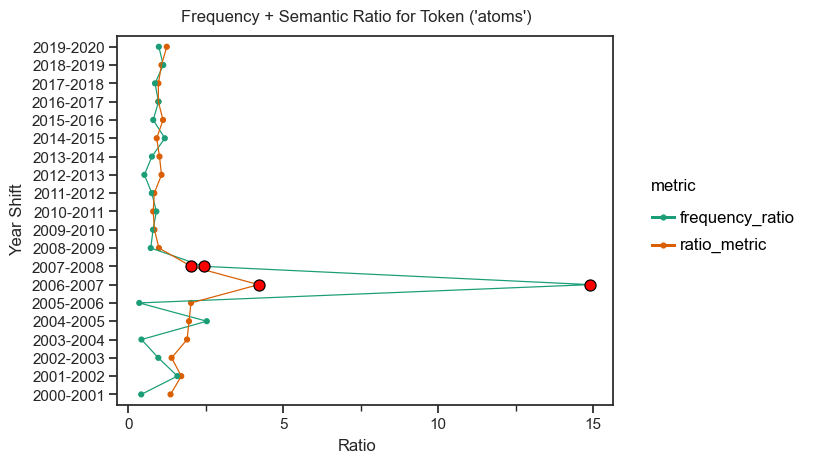

<ggplot: (-9223363260732561797)>

In [21]:
plot_values(change_metric_df, change_point_df, tok="atoms")

In [22]:
token_map = examine_words_at_timepoint_range(
    word_model_cutoff_map,
    [2004, 2005, 2006, 2007, 2008, 2009],
    tok="atoms",
    topn=5,
)
token_map

{2004: ['ps', 'chains', 'ions', 'cytosolic', 'subunits'],
 2005: ['hydrogen', 'bonds', 'coupling', 'helices', 'bond'],
 2006: ['backbone', 'residue', 'coordinates', 'folding', 'bond'],
 2007: ['atom', 'anions', 'distorted', 'octahedral', 'cations'],
 2008: ['atom', 'n_atoms', 'tetrahedral', 'anions', 'bidentate'],
 2009: ['atom', 'n_atoms', 'bidentate', 'anions', 'octahedral']}

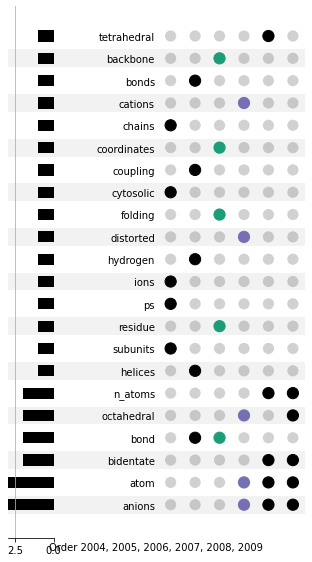

In [23]:
tokens = from_memberships(token_map.values())
fig = plt.figure(figsize=(11, 8))
upset = UpSet(
    tokens,
    with_lines=False,
    show_counts=False,
    sort_by="cardinality",
    intersection_plot_elements=0,
)
upset.style_subsets(present="backbone", facecolor="#1b9e77")
upset.style_subsets(present="cations", facecolor="#7570b3")
axes = UpSet.plot(upset, fig=fig)
axes["shading"].set_xlabel("Order 2004, 2005, 2006, 2007, 2008, 2009")
fig.savefig(f"{str(figure_output_path)}/atoms_changepoint.svg")
fig.savefig(f"{str(figure_output_path)}/atoms_changepoint.png", dpi=500)

## Individual Year Changes

2001 token has a high chance of a shift moving from medical topics from cancer and healthcare to specifying time and dates.
This leads to the question do other years have this short of shift?
Turns out yes 2003 and 2004 have this shift but more data is needed in order to calculate the changepoint timeline (only used tokens present across all the years).

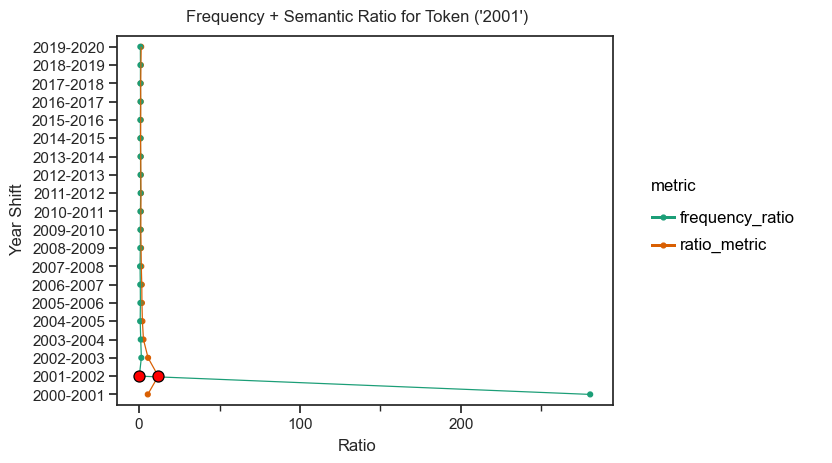

<ggplot: (8776120965075)>

In [24]:
plot_values(change_metric_df, change_point_df, tok="2001")

In [25]:
token_map = examine_words_at_timepoint_range(
    word_model_cutoff_map,
    [2000, 2001, 2002, 2003, 2004],
    tok="2001",
    topn=5,
)

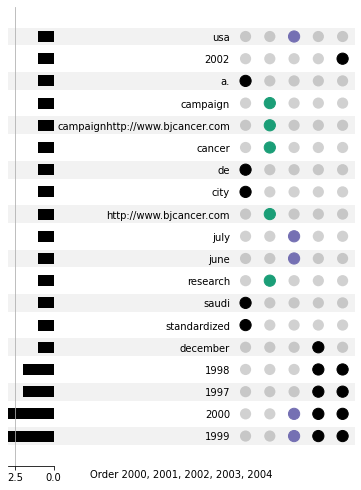

In [26]:
tokens = from_memberships(token_map.values())
fig = plt.figure(figsize=(11, 8))
upset = UpSet(
    tokens,
    with_lines=False,
    show_counts=False,
    sort_by="cardinality",
    intersection_plot_elements=0,
)
upset.style_subsets(present="campaign", facecolor="#1b9e77")
upset.style_subsets(present="july", facecolor="#7570b3")
axes = UpSet.plot(upset, fig=fig)
axes["shading"].set_xlabel("Order 2000, 2001, 2002, 2003, 2004")
fig.savefig(f"{str(figure_output_path)}/2001_changepoint.svg")
fig.savefig(f"{str(figure_output_path)}/2001_changepoint.png", dpi=500)

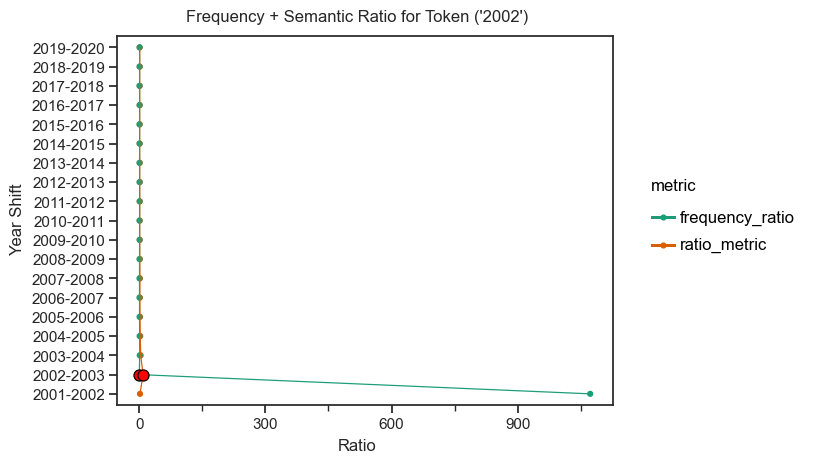

<ggplot: (-9223363260732598591)>

In [27]:
plot_values(change_metric_df, change_point_df, tok="2002")

In [28]:
token_map = examine_words_at_timepoint_range(
    word_model_cutoff_map,
    [2001, 2002, 2003, 2004, 2005],
    tok="2002",
    topn=5,
)
token_map

{2001: ['india', 'germany', 'netherlands', '47', 'eradication'],
 2002: ['british_journal_of_cancer', '87', 'doi:10.1038', '86', 'doi'],
 2003: ['april', '2001', 'september', 'december', 'february'],
 2004: ['2001', '1999', '2000', '1998', '1997'],
 2005: ['2001', '2000', '2003', '1998', '1999']}

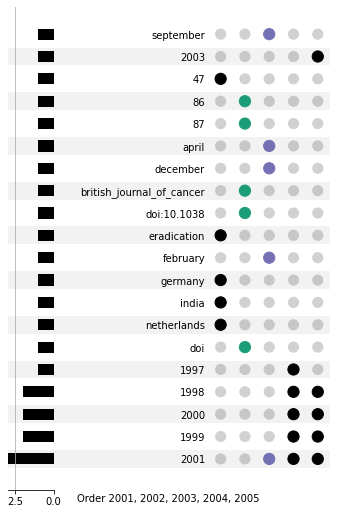

In [29]:
tokens = from_memberships(token_map.values())
fig = plt.figure(figsize=(11, 8))
upset = UpSet(
    tokens,
    with_lines=False,
    show_counts=False,
    sort_by="cardinality",
    intersection_plot_elements=0,
)
upset.style_subsets(present="british_journal_of_cancer", facecolor="#1b9e77")
upset.style_subsets(present="april", facecolor="#7570b3")
axes = UpSet.plot(upset, fig=fig)
axes["shading"].set_xlabel("Order 2001, 2002, 2003, 2004, 2005")
fig.savefig(f"{str(figure_output_path)}/2002_changepoint.svg")
fig.savefig(f"{str(figure_output_path)}/2002_changepoint.png", dpi=500)

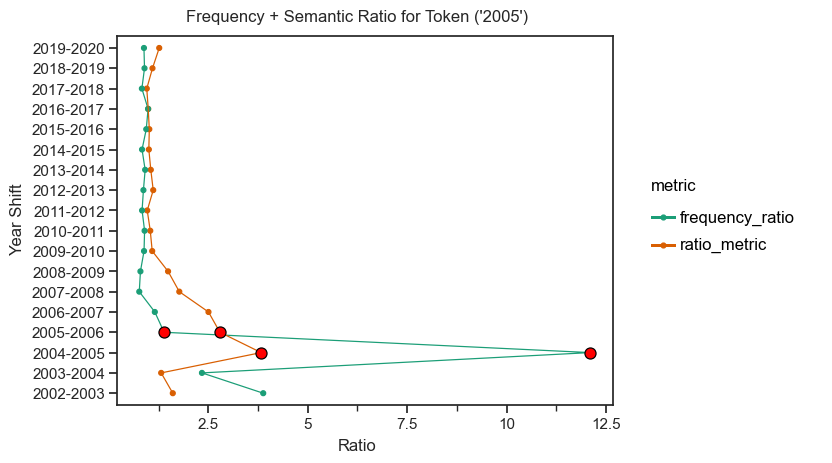

<ggplot: (8776128422166)>

In [30]:
plot_values(change_metric_df, change_point_df, tok="2005")

In [31]:
token_map = examine_words_at_timepoint_range(
    word_model_cutoff_map,
    [2002, 2003, 2004, 2005, 2006, 2007],
    tok="2005",
    topn=5,
)
token_map

{2002: ['believed', 'appeared', 'tended', 'excluded', 'addressed'],
 2003: ['nursing', 'practices', 'facilities', 'residents', 'medicare'],
 2004: ['annual', 'began', 'year', 'market', 'government'],
 2005: ['2004', 'inc', 'usa', 'wiley', 'june'],
 2006: ['2004', 'july', '2003', 'august', 'november'],
 2007: ['2003', '2004', '1996', '2002', '2006']}

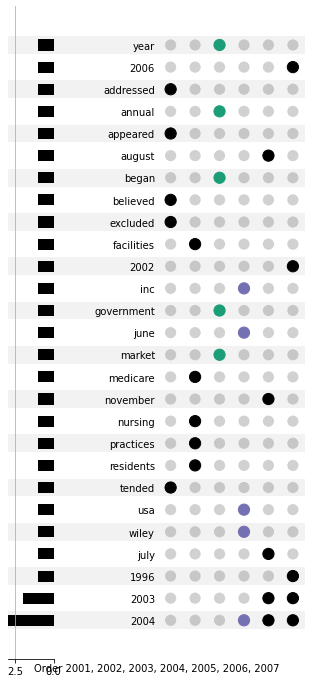

In [32]:
tokens = from_memberships(token_map.values())
fig = plt.figure(figsize=(11, 8))
upset = UpSet(
    tokens,
    with_lines=False,
    show_counts=False,
    sort_by="cardinality",
    intersection_plot_elements=0,
)
upset.style_subsets(present="annual", facecolor="#1b9e77")
upset.style_subsets(present="usa", facecolor="#7570b3")
axes = UpSet.plot(upset, fig=fig)
axes["shading"].set_xlabel("Order 2001, 2002, 2003, 2004, 2005, 2006, 2007")
fig.savefig(f"{str(figure_output_path)}/2005_changepoint.svg")
fig.savefig(f"{str(figure_output_path)}/2005_changepoint.png", dpi=500)

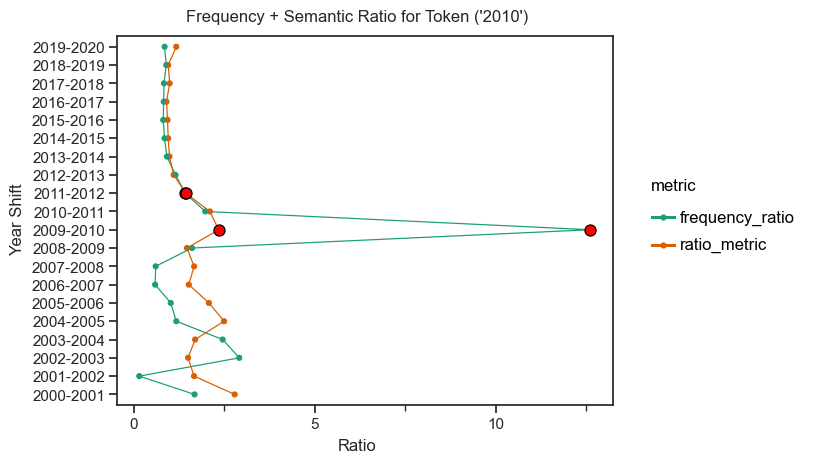

<ggplot: (-9223363260733198767)>

In [33]:
plot_values(change_metric_df, change_point_df, tok="2010")

In [34]:
token_map = examine_words_at_timepoint_range(
    word_model_cutoff_map,
    [2006, 2007, 2008, 2009, 2010, 2011],
    tok="2010",
    topn=5,
)
token_map

{2006: ['federal', 'projected', 'annually', 'us$', 'government'],
 2007: ['millennium', 'cdc', 'legislation', 'government', 'international'],
 2008: ['sponsored', 'issued', 'funded', '2020', 'u.s'],
 2009: ['2020', 'london', 'sponsored', 'government', 'fund'],
 2010: ['2009', 'wiley', 'liss', '2011', 'med'],
 2011: ['2009', '2008', '2007', 'september', 'august']}

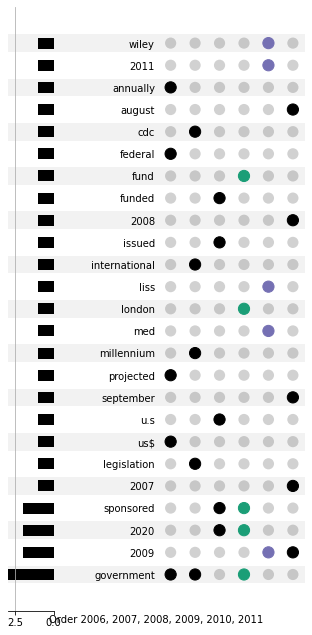

In [35]:
tokens = from_memberships(token_map.values())
fig = plt.figure(figsize=(11, 8))
upset = UpSet(
    tokens,
    with_lines=False,
    show_counts=False,
    sort_by="cardinality",
    intersection_plot_elements=0,
)
upset.style_subsets(present="london", facecolor="#1b9e77")
upset.style_subsets(present="2011", facecolor="#7570b3")
axes = UpSet.plot(upset, fig=fig)
axes["shading"].set_xlabel("Order 2006, 2007, 2008, 2009, 2010, 2011")
fig.savefig(f"{str(figure_output_path)}/2005_changepoint.svg")
fig.savefig(f"{str(figure_output_path)}/2005_changepoint.png", dpi=500)

# Take home points

1. Looks like my model is off by 1 for words such as corona virus and pandemic. This is probably due the way changepoint detection works and changes at the end of the series is hard to detect.
2. Asthma has an association with type 2 diabetes. Thats really interesting as I just hadn't fathomed there was a connection.
3. Years seem to undergo a shift in prevalent topics discussed to time indiciations. Need more data to be processed before I can truly say this trend is possible.
4. Unfortunately, majority of my findings only arise from an increase in frequency. This might change if I were to use full text rather than abstracts.